Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/ISIC_new/Train/")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/ISIC_new/Test/')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

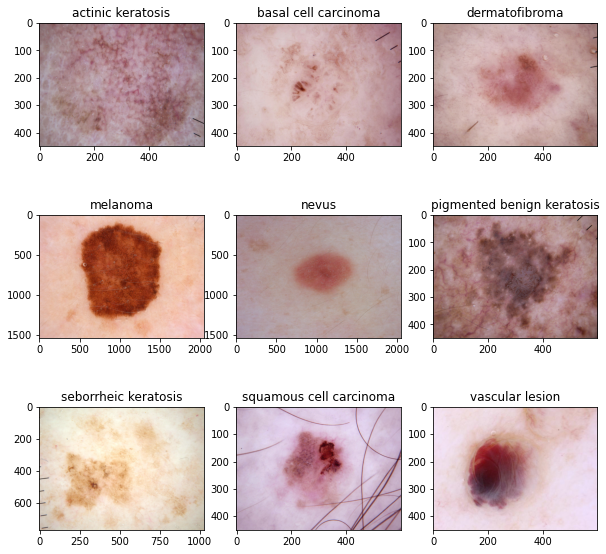

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 471s 2s/step - loss: 2.0525 - accuracy: 0.1780 - val_loss: 1.9983 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 4s 76ms/step - loss: 2.0454 - accuracy: 0.1864 - val_loss: 2.0530 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 4s 75ms/step - loss: 2.0319 - accuracy: 0.2031 - val_loss: 2.0249 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 4s 75ms/step - loss: 2.0206 - accuracy: 0.1908 - val_loss: 2.0156 - val_accuracy: 0.2304
Epoch 5/20
56/56 [==============================] - 4s 75ms/step - loss: 2.0145 - accuracy: 0.2070 - val_loss: 2.0196 - val_accuracy: 0.2506
Epoch 6/20
56/56 [==============================] - 4s 75ms/step - loss: 2.0600 - accuracy: 0.2182 - val_loss: 2.0202 - val_accuracy: 0.2371
Epoch 7/20
56/56 [==============================] - 4s 76ms/step - loss: 2.0176 - accuracy: 0.2042 - val_loss: 2.0140 - val_accuracy: 0.2058
Epoch 8/20
56/56 [======

### Visualizing training results

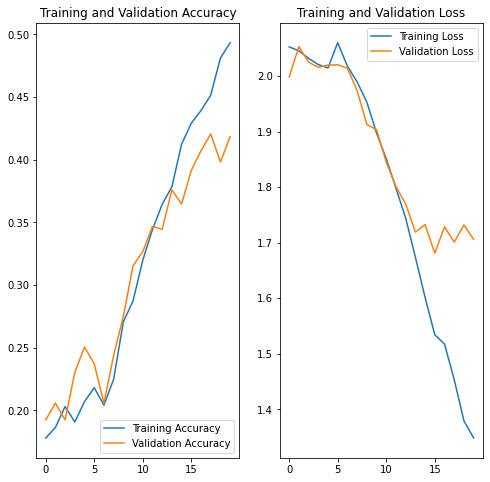

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
#### The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch
#### The accuracy is just around 75-80% because there are enough features to remember the pattern.
#### But again, it's too early to comment on the overfitting & underfitting debate

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

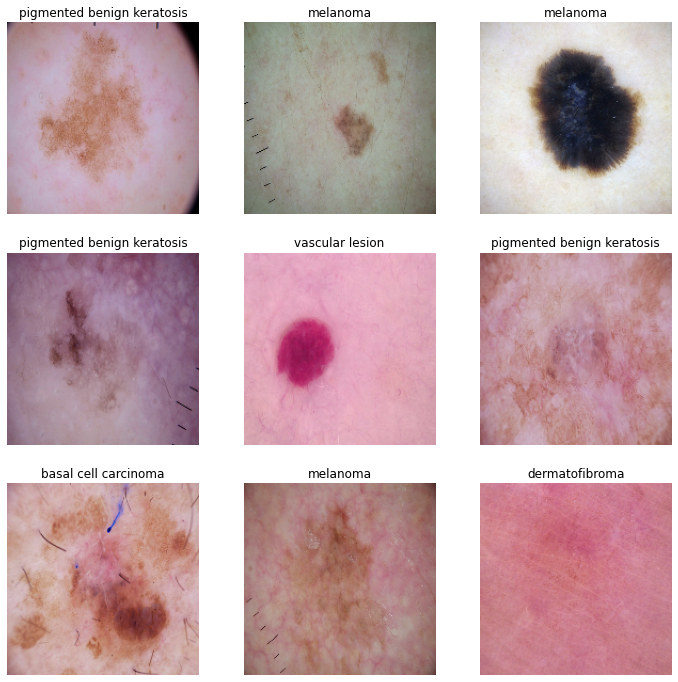

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))



### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 109ms/step - loss: 2.0587 - accuracy: 0.1936 - val_loss: 2.0487 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 6s 103ms/step - loss: 2.0552 - accuracy: 0.2121 - val_loss: 2.0201 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 6s 103ms/step - loss: 2.0116 - accuracy: 0.2109 - val_loss: 2.0110 - val_accuracy: 0.2125
Epoch 4/20
56/56 [==============================] - 6s 103ms/step - loss: 2.0098 - accuracy: 0.2199 - val_loss: 2.0180 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 6s 103ms/step - loss: 1.9870 - accuracy: 0.2455 - val_loss: 1.9124 - val_accuracy: 0.2841
Epoch 6/20
56/56 [==============================] - 6s 103ms/step - loss: 1.9022 - accuracy: 0.2852 - val_loss: 1.9024 - val_accuracy: 0.2707
Epoch 7/20
56/56 [==============================] - 6s 103ms/step - loss: 1.8818 - accuracy: 0.2868 - val_loss: 1.8868 - val_accuracy: 0.3132
Epoch 

### Visualizing the results

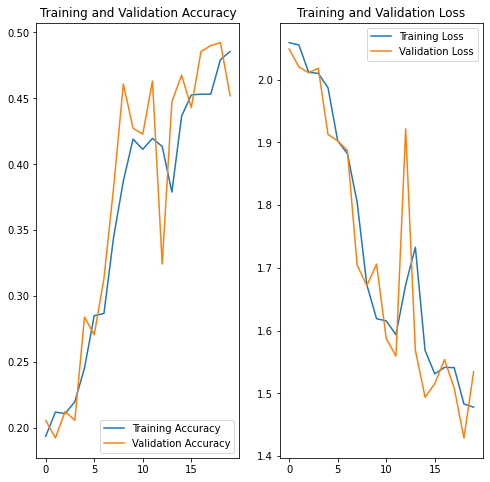

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

#### We can increase the epochs to increase the accuracy so it's too early for judgement

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
## Your code goes here.
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/ISIC_new/Train/actinic...,actinic keratosis
1,/content/gdrive/MyDrive/ISIC_new/Train/actinic...,actinic keratosis
2,/content/gdrive/MyDrive/ISIC_new/Train/actinic...,actinic keratosis
3,/content/gdrive/MyDrive/ISIC_new/Train/actinic...,actinic keratosis
4,/content/gdrive/MyDrive/ISIC_new/Train/actinic...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/ISIC_new/Train/vascula...,vascular lesion
2235,/content/gdrive/MyDrive/ISIC_new/Train/vascula...,vascular lesion
2236,/content/gdrive/MyDrive/ISIC_new/Train/vascula...,vascular lesion
2237,/content/gdrive/MyDrive/ISIC_new/Train/vascula...,vascular lesion


In [23]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/ISIC_new/Train/actinic...,actinic keratosis
1,/content/gdrive/MyDrive/ISIC_new/Train/actinic...,actinic keratosis
2,/content/gdrive/MyDrive/ISIC_new/Train/actinic...,actinic keratosis
3,/content/gdrive/MyDrive/ISIC_new/Train/actinic...,actinic keratosis
4,/content/gdrive/MyDrive/ISIC_new/Train/actinic...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/ISIC_new/Train/vascula...,vascular lesion
2235,/content/gdrive/MyDrive/ISIC_new/Train/vascula...,vascular lesion
2236,/content/gdrive/MyDrive/ISIC_new/Train/vascula...,vascular lesion
2237,/content/gdrive/MyDrive/ISIC_new/Train/vascula...,vascular lesion


<BarContainer object of 9 artists>

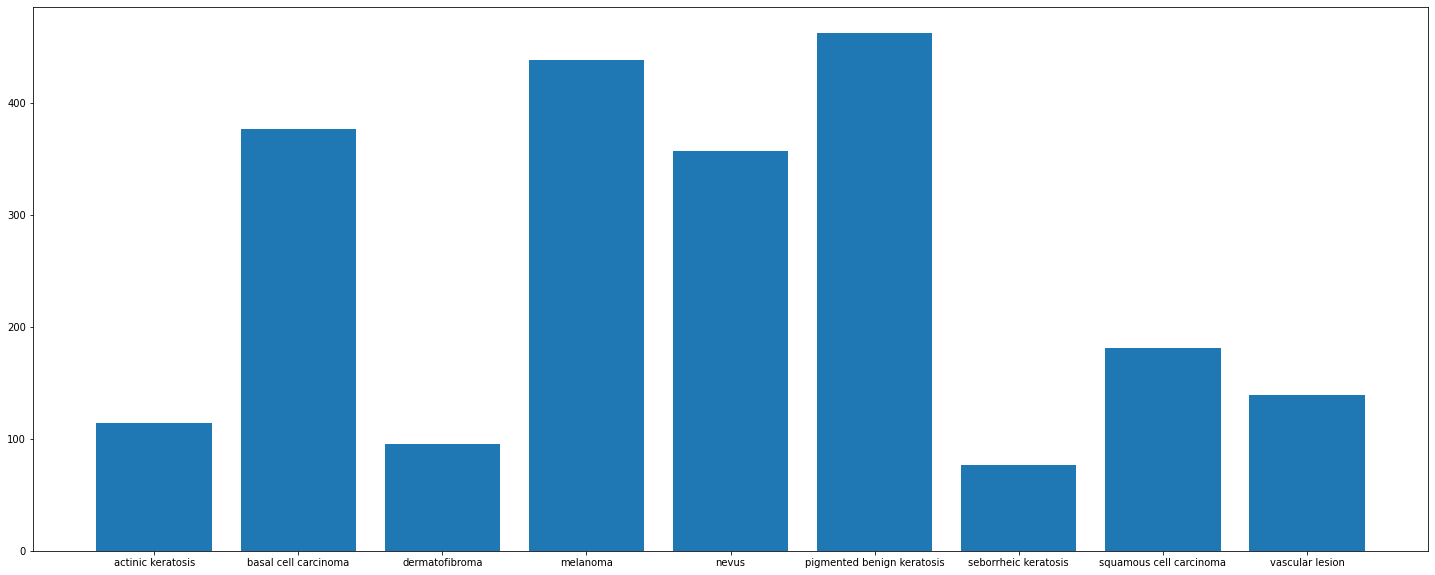

In [24]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

#### Answer-1 :- squamous cell carcinoma has least number of samples

#### Answer-2:- actinic keratosis and dermatofibroma have proportionate number of classes. melanoma and pigmented benign keratosis have proprtionate number of classes


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset="/content/gdrive/MyDrive/ISIC_new/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC_new/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDAA1153DC0>: 100%|██████████| 500/500 [00:21<00:00, 23.29 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC_new/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB1BF73610>: 100%|██████████| 500/500 [00:24<00:00, 20.81 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC_new/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FDB1BFC9580>: 100%|██████████| 500/500 [00:21<00:00, 23.69 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC_new/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FDAB609E220>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC_new/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDB1BFBDA60>: 100%|██████████| 500/500 [01:22<00:00,  6.05 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC_new/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDAB6671BE0>: 100%|██████████| 500/500 [00:19<00:00, 26.29 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC_new/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDB1BF67220>: 100%|██████████| 500/500 [00:45<00:00, 11.02 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC_new/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDAB66E9190>: 100%|██████████| 500/500 [00:18<00:00, 27.25 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/ISIC_new/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDAB66714C0>: 100%|██████████| 500/500 [00:18<00:00, 27.62 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/ISIC_new/Train/')
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
path_list = [x for x in glob.glob(os.path.join('/content/gdrive/MyDrive/ISIC_new/Train/','*','output','*.jpg'))]
path_list

['/content/gdrive/MyDrive/ISIC_new/Train/melanoma/output/melanoma_original_ISIC_0010119.jpg_f39238fb-cf7a-453d-a17e-27e9d58d119f.jpg',
 '/content/gdrive/MyDrive/ISIC_new/Train/melanoma/output/melanoma_original_ISIC_0010080.jpg_cc9faaf6-6294-4ef3-8964-5ed35560b202.jpg',
 '/content/gdrive/MyDrive/ISIC_new/Train/melanoma/output/melanoma_original_ISIC_0010900.jpg_922eacec-ef2e-421c-8297-1fbc6b68750f.jpg',
 '/content/gdrive/MyDrive/ISIC_new/Train/melanoma/output/melanoma_original_ISIC_0000554.jpg_f64a974e-fe6a-4deb-af68-46a05ecfbd3d.jpg',
 '/content/gdrive/MyDrive/ISIC_new/Train/melanoma/output/melanoma_original_ISIC_0000511.jpg_a7c27702-c80e-4858-b374-2c7c0495b97a.jpg',
 '/content/gdrive/MyDrive/ISIC_new/Train/melanoma/output/melanoma_original_ISIC_0010039.jpg_f0ad2e67-c0af-473d-b45e-5d5f8a5830a1.jpg',
 '/content/gdrive/MyDrive/ISIC_new/Train/melanoma/output/melanoma_original_ISIC_0010417.jpg_e507776c-6a86-4902-8086-685ce7ccb916.jpg',
 '/content/gdrive/MyDrive/ISIC_new/Train/melanoma/outpu

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join('/content/gdrive/MyDrive/ISIC_new/Train/','*','output','*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)
new_df

,Path,Label
0,/content/gdrive/MyDrive/ISIC_new/Train/actinic...,actinic keratosis
1,/content/gdrive/MyDrive/ISIC_new/Train/actinic...,actinic keratosis
2,/content/gdrive/MyDrive/ISIC_new/Train/actinic...,actinic keratosis
3,/content/gdrive/MyDrive/ISIC_new/Train/actinic...,actinic keratosis
4,/content/gdrive/MyDrive/ISIC_new/Train/actinic...,actinic keratosis
...,...,...
4495,/content/gdrive/MyDrive/ISIC_new/Train/dermato...,dermatofibroma
4496,/content/gdrive/MyDrive/ISIC_new/Train/dermato...,dermatofibroma
4497,/content/gdrive/MyDrive/ISIC_new/Train/dermato...,dermatofibroma
4498,/content/gdrive/MyDrive/ISIC_new/Train/dermato...,dermatofibroma


In [33]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
data_dir_train="/content/gdrive/MyDrive/ISIC_new/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [37]:
## your code goes here
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [38]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [39]:
#epochs = 30
## Your code goes here, use 50 epochs.
#history = # your model fit code

epochs =50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 39s 215ms/step - loss: 2.1544 - accuracy: 0.1810 - val_loss: 1.9426 - val_accuracy: 0.3044
Epoch 2/50
169/169 [==============================] - 36s 208ms/step - loss: 1.7389 - accuracy: 0.3316 - val_loss: 1.6161 - val_accuracy: 0.3764
Epoch 3/50
169/169 [==============================] - 34s 196ms/step - loss: 1.6628 - accuracy: 0.3631 - val_loss: 1.7513 - val_accuracy: 0.3341
Epoch 4/50
169/169 [==============================] - 34s 197ms/step - loss: 1.5983 - accuracy: 0.3861 - val_loss: 1.7226 - val_accuracy: 0.3370
Epoch 5/50
169/169 [==============================] - 34s 197ms/step - loss: 1.4377 - accuracy: 0.4527 - val_loss: 1.6344 - val_accuracy: 0.3831
Epoch 6/50
169/169 [==============================] - 34s 197ms/step - loss: 1.3673 - accuracy: 0.4790 - val_loss: 1.2885 - val_accuracy: 0.5264
Epoch 7/50
169/169 [==============================] - 36s 205ms/step - loss: 1.2307 - accuracy: 0.5365 - val_loss: 1.3248 - val_accuracy: 0.5

#### **Todo:**  Visualize the model results

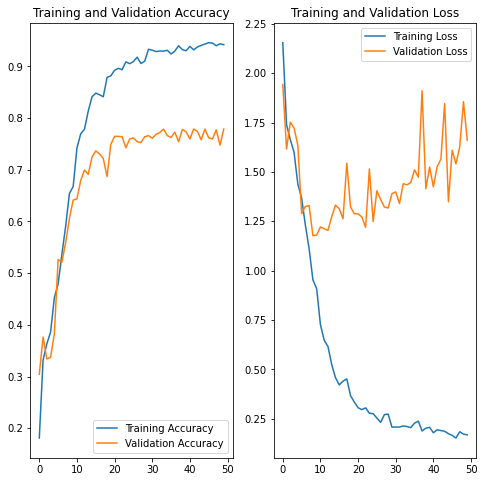

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- Accuracy on training data has increased by using Augmentor library

- Model is still overfitting

- The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

- The Model can be further improved by tuning the hyperparameter